## Sentiment Analysis

In this exercise we use the IMDb-dataset, which we will use to perform a sentiment analysis. The code below assumes that the data is placed in the same folder as this notebook. We see that the reviews are loaded as a pandas dataframe, and print the beginning of the first few reviews.

**(a)** Split the reviews and labels in test, train and validation sets. The train and validation sets will be used to train your model and tune hyperparameters, the test set will be saved for testing. Use the `CountVectorizer` from `sklearn.feature_extraction.text` to create a Bag-of-Words representation of the reviews. Only use the 10,000 most frequent words (use the `max_features`-parameter of `CountVectorizer`).

**(b)** Explore the representation of the reviews. How is a single word represented? How about a whole review?

**(c)** Train a neural network with a single hidden layer on the dataset, tuning the relevant hyperparameters to optimize accuracy. 

**(d)** Test your sentiment-classifier on the test set.

**(e)** Use the classifier to classify a few sentences you write yourselves. 

In [2]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [32]:
# File paths
reviews_file = 'reviews.txt'
labels_file = 'labels.txt'

# Read the files into lists
with open(reviews_file, 'r') as rf:
    reviews = rf.readlines()

with open(labels_file, 'r') as lf:
    labels = lf.readlines()

# Remove newline characters
reviews = [review.strip() for review in reviews]
labels = [label.strip() for label in labels]

# Create a DataFrame
df = pd.DataFrame({'review': reviews, 'label': labels})

# Display the DataFrame
display(df)

,review,label
0,bromwell high is a cartoon comedy . it ran at ...,positive
1,story of a man who has unnatural feelings for ...,negative
2,homelessness or houselessness as george carli...,positive
3,airport starts as a brand new luxury pla...,negative
4,brilliant over acting by lesley ann warren . ...,positive
...,...,...
24995,i saw descent last night at the stockholm fi...,negative
24996,a christmas together actually came before my t...,positive
24997,some films that you pick up for a pound turn o...,negative
24998,working class romantic drama from director ma...,positive


# Reviews analysis

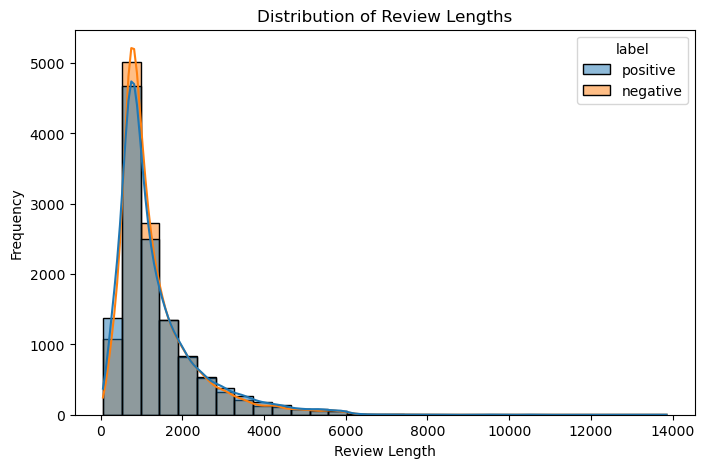

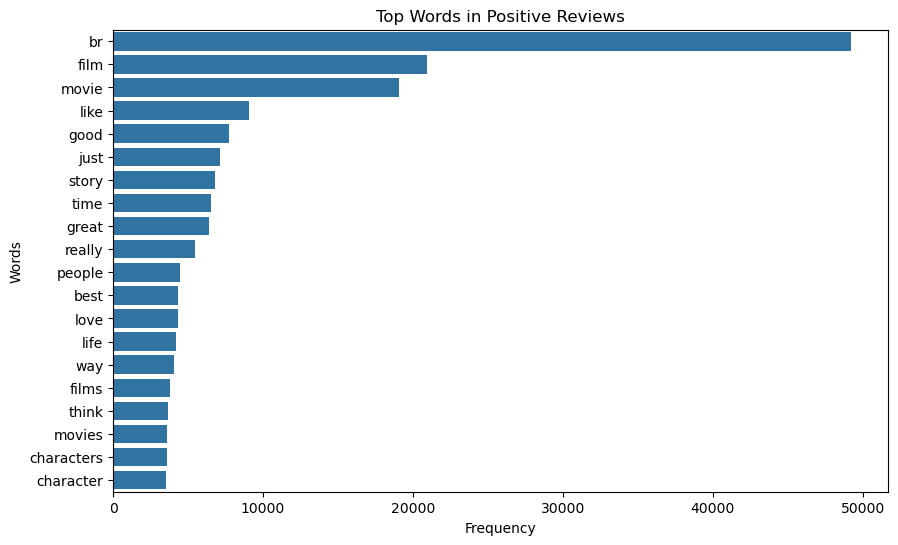

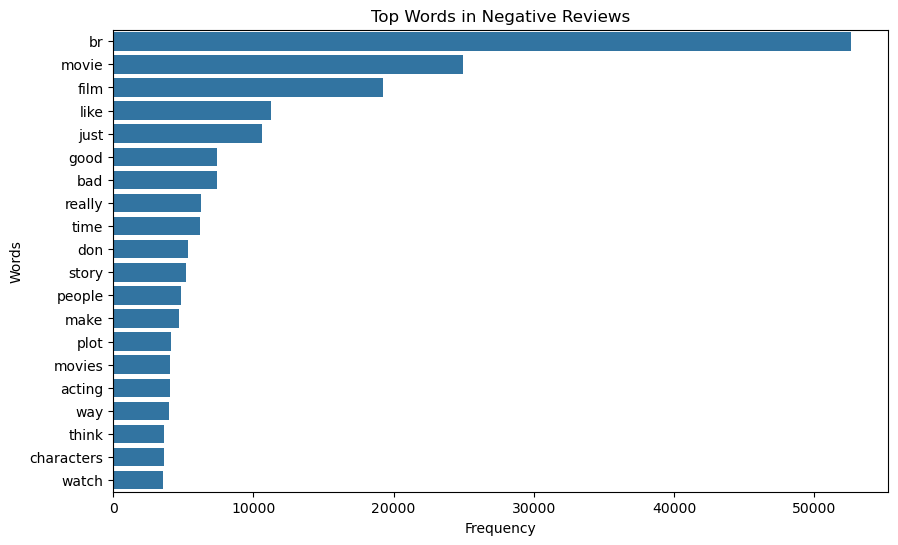

In [33]:
df['review_length'] = df['review'].apply(len)

# Total number of reviews in each category
category_counts = df['label'].value_counts()

# Average length of reviews per category
average_lengths = df.groupby('label')['review_length'].mean()

# Distribution of review lengths
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='review_length', hue='label', kde=True, bins=30)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

# Word Frequency Analysis
# Vectorize the text to extract word counts
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['review'])
word_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
word_counts['label'] = df['label']

# Summing up the word frequencies for positive and negative reviews
positive_words = word_counts[df['label'] == 'positive'].drop('label', axis=1).sum().sort_values(ascending=False)
negative_words = word_counts[df['label'] == 'negative'].drop('label', axis=1).sum().sort_values(ascending=False)

# Visualizing Most Common Words
def plot_common_words(word_series, title):
    top_words = word_series.head(20)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_words.values, y=top_words.index)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

plot_common_words(positive_words, 'Top Words in Positive Reviews')
plot_common_words(negative_words, 'Top Words in Negative Reviews')

Length of reviews: it seems that llengths of both positive and negative reviews are mostly the same, so this isn't a factor that'd play a significant role.
Most common words: 
* In the charts of most common words, br (line break) seems to be the most occuring one. This is not a word, but it makes sense that it's the most common in this dataset.
* From the looks of it, the most common words seem to be pretty similar, except for some like: "bad", "great", or "plot"

In [34]:
# The words with largest differences between reviews types

positive_diff = (positive_words - negative_words).sort_values(ascending=False)
negative_diff = (negative_words - positive_words).sort_values(ascending=False)

display(positive_diff.head(10))
display(negative_diff.head(10))

great        3779
best         2225
love         2149
life         1770
film         1719
story        1572
excellent    1295
wonderful    1086
young        1026
world        1025
dtype: int64

movie     5891
bad       5494
just      3467
br        3402
worst     2228
like      2200
don       1868
plot      1722
acting    1619
make      1419
dtype: int64

Since the numbers in tables above can also be caused because they are just common, we need to compare them with the total number of instances. \
But we'll only take the 30 most different words in number, since we don't want to include words that only appear once or twice

In [35]:
negative_diff = negative_diff.head(30)
positive_diff = positive_diff.head(30)

positive_total = positive_words.loc[positive_diff.index] + negative_words.loc[positive_diff.index]
negative_total = positive_words.loc[negative_diff.index] + negative_words.loc[negative_diff.index]

positive_comparison = pd.DataFrame({
    'word': positive_diff.index,
    'difference': positive_diff.values,
    'total': positive_total.values,
    'proportion': (positive_diff / positive_total).values
}).sort_values(by='proportion', ascending=False)

negative_comparison = pd.DataFrame({
    'word': negative_diff.index,
    'difference': negative_diff.values,
    'total': negative_total.values,
    'proportion': (negative_diff / negative_total).values
}).sort_values(by='proportion', ascending=False)

display(positive_comparison)
display(negative_comparison)

,word,difference,total,proportion
7,wonderful,1086,1658,0.655006
6,excellent,1295,2071,0.625302
17,amazing,796,1320,0.603030
21,favorite,692,1232,0.561688
15,perfect,886,1598,0.554443
25,brilliant,656,1196,0.548495
18,loved,746,1428,0.522409
28,today,627,1245,0.503614
11,beautiful,984,2176,0.452206
0,great,3779,9059,0.417154


,word,difference,total,proportion
12,waste,1259,1457,0.864104
4,worst,2228,2732,0.815520
10,awful,1389,1725,0.805217
24,horrible,891,1201,0.741882
28,crap,751,1039,0.722810
19,worse,1029,1469,0.700477
16,terrible,1144,1638,0.698413
14,stupid,1155,1701,0.679012
15,boring,1145,1811,0.632247
1,bad,5494,9308,0.590245


As to be expected, very emotionally strong words for and against someone's liking seem to be a good predictor of wether the review is positive or negative.

## Vectorizing text and spliting into train test validate

In [37]:
df["label"] = df["label"].map({"negative": 0, "positive": 1})

In [40]:
vectorizer = CountVectorizer(max_features=10000)

X = vectorizer.fit_transform(df['review']).toarray()

In [41]:
X_, X_test, y_, y_test = train_test_split(X, df['label'], train_size=.8, random_state=504)
X_train, X_validate, y_train, y_validate = train_test_split(X_, y_, train_size=.75, random_state=504)

## Training and validation

In [42]:
ann = tf.keras.Sequential([
    tf.keras.layers.Dense(units=50, input_dim=X.shape[1], activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

ann.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy']) 

/Users/mhv/.pyenv/versions/anaconda3-2023.07-2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
es = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

history = ann.fit(X_train, y_train, epochs = 100, validation_data=(X_validate, y_validate), callbacks=[es])

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7990 - loss: 0.4762 - val_accuracy: 0.8784 - val_loss: 0.3027
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9397 - loss: 0.1611 - val_accuracy: 0.8800 - val_loss: 0.3376
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9670 - loss: 0.0868 - val_accuracy: 0.8694 - val_loss: 0.4798
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9742 - loss: 0.0654 - val_accuracy: 0.8696 - val_loss: 0.5162
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9819 - loss: 0.0492 - val_accuracy: 0.8676 - val_loss: 0.7017
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9864 - loss: 0.0341 - val_accuracy: 0.8646 - val_loss: 0.6771
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9926 - loss: 0.0197 - val_accuracy: 0.8738 - val_loss: 0.8769
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9899 - loss: 0.0313 - val_accu

In [57]:
test_results = ann.evaluate(X_test, y_test, batch_size=128)

print('Test loss:', test_results[0])
print('Test accuracy:', test_results[1])

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8807 - loss: 0.2994
Test loss: 0.3023627996444702
Test accuracy: 0.8804000020027161


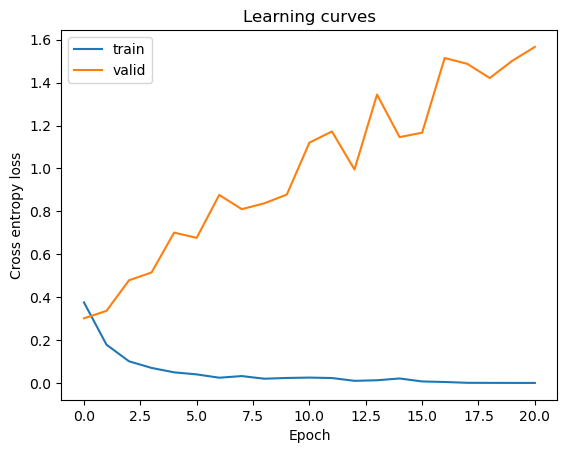

In [44]:
plt.figure()
plt.title("Learning curves")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')
plt.legend()
plt.show()

In [53]:
prediction = (ann.predict(X_test) > 0.5).astype(int).flatten()
print(len(prediction))
len(y_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
5000


5000

## Testing with own text

Custom reviews

In [74]:
test_text = [
    "hate",
    "like",
    "I love this movie",
    "I hate this movie",
    "This movie is amazing, said no one",
    "How can you hate on this movie?"
]

test_X = vectorizer.transform(test_text).toarray()

In [75]:
custom_predictions = ann.predict(test_X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [76]:
predicted_labels = (custom_predictions > 0.5).astype(int).flatten()

for text, label in zip(test_text, predicted_labels):
    sentiment = 'positive' if label == 1 else 'negative'
    print(f"Text: {text} -> Sentiment: {sentiment}")

Text: hate -> Sentiment: positive
Text: like -> Sentiment: negative
Text: I love this movie -> Sentiment: positive
Text: I hate this movie -> Sentiment: positive
Text: This movie is amazing, said no one -> Sentiment: positive
Text: How can you hate on this movie? -> Sentiment: positive


Generated reviews

In [77]:
test_text = [
    "An absolute masterpiece! The storyline was engaging from start to finish, with exceptional performances by the cast. The visuals were stunning, and the director's attention to detail truly brought the movie to life. A must-watch for anyone who loves cinema.",
    "This film exceeded all my expectations! The characters felt real and relatable, and the emotional depth kept me hooked. The soundtrack perfectly complemented the scenes, making the experience unforgettable. I can't wait to see it again!",
    "What a disappointment. The plot was shallow and predictable, and the characters lacked any real development. It felt like a waste of time and money. Definitely not something I would recommend to anyone.",
    "Terribly executed. The pacing was all over the place, and the dialogue felt forced and unnatural. It was as if the creators didn't know what story they wanted to tell. I struggled to sit through the entire thing.",
    "An incredible film that left me speechless. The plot twists were unpredictable, and the acting was top-notch. This is one of the best movies I've seen in years!",
    "Absolutely loved it! The cinematography was breathtaking, and the story was so moving. I felt emotionally connected to the characters throughout the film.",
    "I found this movie incredibly boring. The plot dragged on with no real purpose, and the acting felt uninspired. I wouldn't recommend it.",
    "One of the worst movies I've ever watched. The storyline was nonsensical, and the editing was a complete mess. It felt like a chore to sit through.",
]


test_X = vectorizer.transform(test_text).toarray()

In [78]:
generated_predictions = ann.predict(test_X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [79]:
predicted_labels = (generated_predictions > 0.5).astype(int).flatten()

for text, label in zip(test_text, predicted_labels):
    sentiment = 'positive' if label == 1 else 'negative'
    print(f"Text: {text} \n Sentiment: {sentiment}")

Text: An absolute masterpiece! The storyline was engaging from start to finish, with exceptional performances by the cast. The visuals were stunning, and the director's attention to detail truly brought the movie to life. A must-watch for anyone who loves cinema. 
 Sentiment: positive
Text: This film exceeded all my expectations! The characters felt real and relatable, and the emotional depth kept me hooked. The soundtrack perfectly complemented the scenes, making the experience unforgettable. I can't wait to see it again! 
 Sentiment: positive
Text: What a disappointment. The plot was shallow and predictable, and the characters lacked any real development. It felt like a waste of time and money. Definitely not something I would recommend to anyone. 
 Sentiment: negative
Text: Terribly executed. The pacing was all over the place, and the dialogue felt forced and unnatural. It was as if the creators didn't know what story they wanted to tell. I struggled to sit through the entire thing.

From what we can see, the model does fairly accurate prediction, but that only applies to review that are long enough to contain a large amount of words. \
When it comes to short reviews, the model is struggling to predict anything as it doesn't have data to evaluate if one word is positive or negative. \
Below, we can see that the predictions themselves were very close to 0.5 for custom reviews, which means that the model was very indecisive. \
As we could see on the gaussian distributuion in the analysis part, the number of characters is usually around 1000, which is considerably more than what we've inputed in our custom reviews.

In [82]:
display(custom_predictions)
display(generated_predictions)

array([[0.54352564],
       [0.49850154],
       [0.572901  ],
       [0.51941323],
       [0.5401804 ],
       [0.56830335]], dtype=float32)

array([[0.7570862 ],
       [0.8259111 ],
       [0.05428366],
       [0.3514775 ],
       [0.86096317],
       [0.77708834],
       [0.1326503 ],
       [0.10003256]], dtype=float32)